In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score



import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    print("Using CUDA (GPU)")
    device = torch.device("cuda")

elif torch.backends.mps.is_available():
    print("Using MPS (macOS)")
    device = torch.device("mps")
else:
    print("Using CPU (Default)")
    device = torch.device("cpu")

Using CUDA (GPU)


In [15]:
full_dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv")

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())
#check difference between the two datasets with duplicate rows and without

full_dataset = full_dataset.drop_duplicates()

print("Duplicate rows in full_dataset:", full_dataset.duplicated().sum())


print("full_dataset shape:", full_dataset.shape)
#check for null values

print("Null values in full_dataset:", full_dataset.isnull().sum().sum())
#no NANs cool
full_dataset = full_dataset.drop(columns=["Education", "Income","Fruits","Veggies","AnyHealthcare","NoDocbcCost" ])


full_dataset



Duplicate rows in full_dataset: 23899
Duplicate rows in full_dataset: 0
full_dataset shape: (229781, 22)
Null values in full_dataset: 0


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,7.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,30.0,1.0,0.0,9.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,1.0,5.0
253676,2.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0
253677,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
253678,0.0,1.0,0.0,1.0,23.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,7.0


In [16]:
skew=full_dataset[["BMI","Age","PhysHlth","MentHlth"]].skew()
skew

BMI         2.063938
Age        -0.385147
PhysHlth    2.046245
MentHlth    2.546808
dtype: float64

In [17]:


from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
full_dataset[["BMI","Age","PhysHlth","MentHlth"]]=Scaler.fit_transform(full_dataset[["BMI","Age","PhysHlth","MentHlth"]])

full_dataset

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,1.667220,1.0,0.0,0.0,0.0,0.0,5.0,1.879074,1.141300,1.0,0.0,0.295241
1,0.0,0.0,0.0,0.0,-0.543101,1.0,0.0,0.0,1.0,0.0,3.0,-0.454434,-0.516791,0.0,0.0,-0.351213
2,0.0,1.0,1.0,1.0,-0.101037,0.0,0.0,0.0,0.0,0.0,5.0,3.434746,2.799391,1.0,0.0,0.295241
3,0.0,1.0,0.0,1.0,-0.248391,0.0,0.0,0.0,1.0,0.0,2.0,-0.454434,-0.516791,0.0,0.0,0.941695
4,0.0,1.0,1.0,1.0,-0.690456,0.0,0.0,0.0,1.0,0.0,2.0,-0.065516,-0.516791,0.0,0.0,0.941695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,2.403993,0.0,0.0,0.0,0.0,0.0,3.0,-0.454434,0.035906,0.0,1.0,-0.997666
253676,2.0,1.0,1.0,1.0,-1.574584,0.0,0.0,0.0,0.0,0.0,4.0,-0.454434,-0.516791,1.0,0.0,0.941695
253677,0.0,0.0,0.0,1.0,-0.101037,0.0,0.0,0.0,1.0,0.0,1.0,-0.454434,-0.516791,0.0,0.0,-1.967347
253678,0.0,1.0,0.0,1.0,-0.837810,0.0,0.0,0.0,0.0,0.0,3.0,-0.454434,-0.516791,0.0,1.0,-0.351213


In [18]:
from sklearn.preprocessing import QuantileTransformer
QT=QuantileTransformer(n_quantiles=100, random_state=0,output_distribution='normal')
full_dataset[["BMI","Age","PhysHlth","MentHlth"]]=QT.fit_transform(full_dataset[["BMI","Age","PhysHlth","MentHlth"]])
full_dataset

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age
0,0.0,1.0,1.0,1.0,1.549706,1.0,0.0,0.0,0.0,0.0,5.0,1.441318,1.144237,1.0,0.0,0.152506
1,0.0,0.0,0.0,0.0,-0.501298,1.0,0.0,0.0,1.0,0.0,3.0,-5.199338,-5.199338,0.0,0.0,-0.444660
2,0.0,1.0,1.0,1.0,0.088734,0.0,0.0,0.0,0.0,0.0,5.0,5.199338,5.199338,1.0,0.0,0.152506
3,0.0,1.0,0.0,1.0,-0.114185,0.0,0.0,0.0,1.0,0.0,2.0,-5.199338,-5.199338,0.0,0.0,0.852495
4,0.0,1.0,1.0,1.0,-0.698526,0.0,0.0,0.0,1.0,0.0,2.0,0.747859,-5.199338,0.0,0.0,0.852495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,0.0,1.0,1.0,1.0,1.985058,0.0,0.0,0.0,0.0,0.0,3.0,-5.199338,0.747859,0.0,1.0,-0.927754
253676,2.0,1.0,1.0,1.0,-2.322575,0.0,0.0,0.0,0.0,0.0,4.0,-5.199338,-5.199338,1.0,0.0,0.852495
253677,0.0,0.0,0.0,1.0,0.088734,0.0,0.0,0.0,1.0,0.0,1.0,-5.199338,-5.199338,0.0,0.0,-1.746017
253678,0.0,1.0,0.0,1.0,-0.927754,0.0,0.0,0.0,0.0,0.0,3.0,-5.199338,-5.199338,0.0,1.0,-0.444660


In [19]:
skew=full_dataset[["BMI","Age","PhysHlth","MentHlth"]].skew()
skew


BMI        -0.000393
Age         0.921846
PhysHlth    0.778369
MentHlth    0.990947
dtype: float64

In [20]:
print("duplicate rows in full_dataset:", full_dataset.duplicated().sum())

duplicate rows in full_dataset: 63678


In [21]:
full_dataset=full_dataset.drop_duplicates()

<Figure size 1200x1000 with 0 Axes>

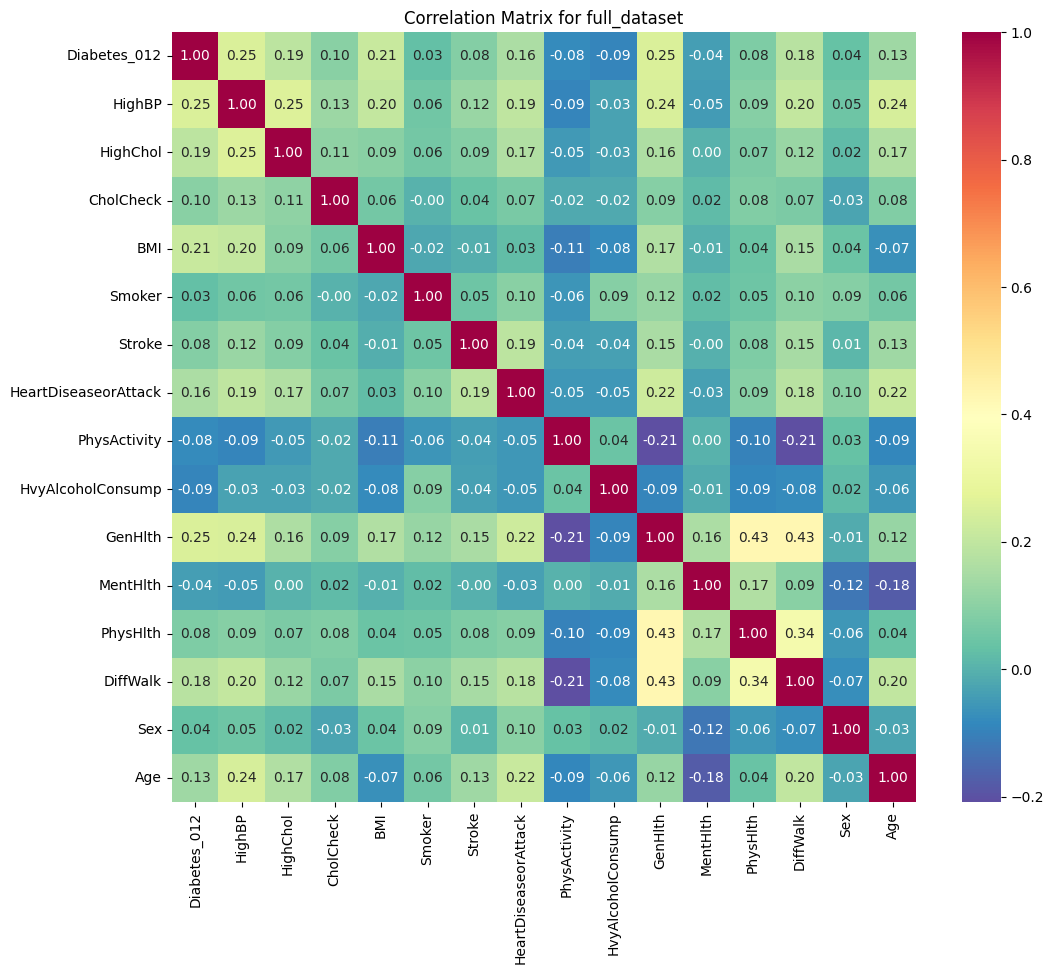

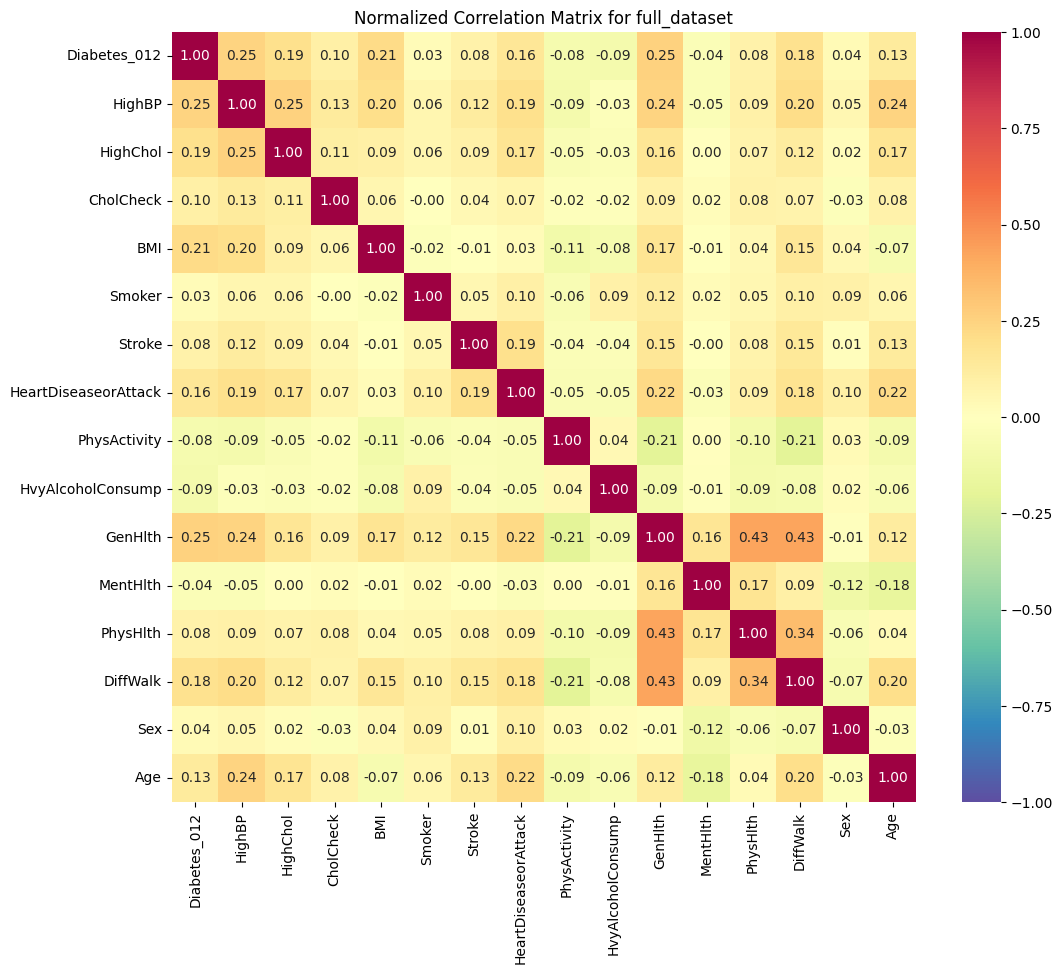

In [22]:
full_corr_matrix = full_dataset.corr()
plt.figure(figsize=(12, 10))


plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r")
plt.title("Correlation Matrix for full_dataset")
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(full_corr_matrix, annot=True, fmt=".2f", cmap="Spectral_r", vmin=-1, vmax=1)
plt.title("Normalized Correlation Matrix for full_dataset")
plt.show()

Diabetes_012
0.0    0.783490
2.0    0.189346
1.0    0.027164
Name: proportion, dtype: float64

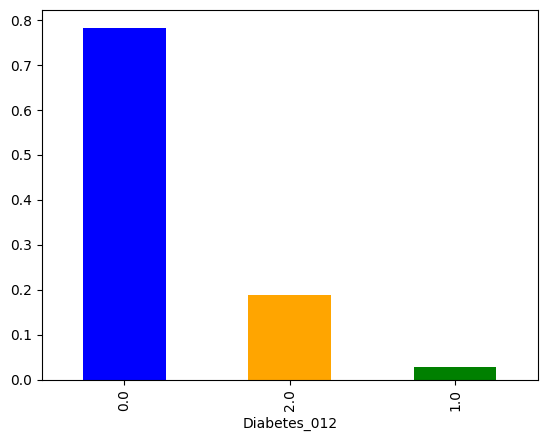

In [23]:
full_dataset["Diabetes_012"].value_counts(normalize=True).plot(kind="bar", color=["blue", "orange", "green"])
full_dataset["Diabetes_012"].value_counts(normalize=True)


In [24]:
crosstab_result = pd.crosstab(full_dataset['HighBP'],full_dataset['Diabetes_012'])
print(crosstab_result)
print((full_dataset.groupby('Diabetes_012')['HighBP'].value_counts())/full_dataset.groupby('Diabetes_012')['HighBP'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HighChol'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HighChol'].value_counts())/full_dataset.groupby('Diabetes_012')['HighChol'].count()*100 ,"\n")



crosstab_result = pd.crosstab(full_dataset['HeartDiseaseorAttack'],full_dataset['Diabetes_012'])
print(crosstab_result,"\n")
print((full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].value_counts())/full_dataset.groupby('Diabetes_012')['HeartDiseaseorAttack'].count()*100 ,"\n")


crosstab_result = pd.crosstab(full_dataset['PhysActivity'],full_dataset['Diabetes_012'])
print(crosstab_result),"\n"
print((full_dataset.groupby('Diabetes_012')['PhysActivity'].value_counts())/full_dataset.groupby('Diabetes_012')['PhysActivity'].count()*100 ,"\n")


Diabetes_012    0.0   1.0    2.0
HighBP                          
0.0           74308  1686   8040
1.0           55832  2826  23411
Diabetes_012  HighBP
0.0           0.0       57.098509
              1.0       42.901491
1.0           1.0       62.632979
              0.0       37.367021
2.0           1.0       74.436425
              0.0       25.563575
dtype: float64 

Diabetes_012    0.0   1.0    2.0
HighChol                        
0.0           75023  1725  10574
1.0           55117  2787  20877 

Diabetes_012  HighChol
0.0           0.0         57.647918
              1.0         42.352082
1.0           1.0         61.768617
              0.0         38.231383
2.0           1.0         66.379447
              0.0         33.620553
dtype: float64 

Diabetes_012             0.0   1.0    2.0
HeartDiseaseorAttack                     
0.0                   116484  3853  23913
1.0                    13656   659   7538 

Diabetes_012  HeartDiseaseorAttack
0.0           0.0              

In [25]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)
X = full_dataset.drop(columns=["Diabetes_012"])
y = full_dataset["Diabetes_012"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Logistic Regression Accuracy: 0.7909153848469341
Confusion Matrix:
 [[25082     0   946]
 [  826     0    77]
 [ 5097     0  1193]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     26028
         1.0       0.00      0.00      0.00       903
         2.0       0.54      0.19      0.28      6290

    accuracy                           0.79     33221
   macro avg       0.45      0.38      0.39     33221
weighted avg       0.74      0.79      0.74     33221



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [26]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.7929923843352097
Confusion Matrix:
 [[25248     0   780]
 [  829     0    74]
 [ 5194     0  1096]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.97      0.88     26028
         1.0       0.00      0.00      0.00       903
         2.0       0.56      0.17      0.27      6290

    accuracy                           0.79     33221
   macro avg       0.46      0.38      0.38     33221
weighted avg       0.74      0.79      0.74     33221



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [27]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.7361307606634357
Confusion Matrix:
 [[22827   182  3019]
 [  724     2   177]
 [ 4611    53  1626]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.88      0.84     26028
         1.0       0.01      0.00      0.00       903
         2.0       0.34      0.26      0.29      6290

    accuracy                           0.74     33221
   macro avg       0.39      0.38      0.38     33221
weighted avg       0.70      0.74      0.72     33221



In [28]:
from imblearn.over_sampling import SMOTE

# Separate features and target variable


# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Diabetes_012'])], axis=1)

print("Original dataset shape:", full_dataset['Diabetes_012'].value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

Original dataset shape: Diabetes_012
0.0    130140
2.0     31451
1.0      4512
Name: count, dtype: int64
Resampled dataset shape: Diabetes_012
0.0    130140
2.0    130140
1.0    130140
Name: count, dtype: int64


In [29]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Logistic Regression Accuracy: 0.5055196967368475
Confusion Matrix:
 [[15335  5622  5071]
 [ 7145  9713  9170]
 [ 4438  7165 14425]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.57      0.59      0.58     26028
         1.0       0.43      0.37      0.40     26028
         2.0       0.50      0.55      0.53     26028

    accuracy                           0.51     78084
   macro avg       0.50      0.51      0.50     78084
weighted avg       0.50      0.51      0.50     78084



In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.7428666564212899
Confusion Matrix:
 [[19156  1596  5276]
 [  963 21866  3199]
 [ 3168  5876 16984]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.74      0.78     26028
         1.0       0.75      0.84      0.79     26028
         2.0       0.67      0.65      0.66     26028

    accuracy                           0.74     78084
   macro avg       0.75      0.74      0.74     78084
weighted avg       0.75      0.74      0.74     78084



In [31]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.8604579683417858
Confusion Matrix:
 [[22728   316  2984]
 [  758 24369   901]
 [ 4369  1568 20091]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.87      0.84     26028
         1.0       0.93      0.94      0.93     26028
         2.0       0.84      0.77      0.80     26028

    accuracy                           0.86     78084
   macro avg       0.86      0.86      0.86     78084
weighted avg       0.86      0.86      0.86     78084



In [32]:
from imblearn.over_sampling import ADASYN
Adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = Adasyn.fit_resample(X, y)
# Combine resampled features and target into a new DataFrame
resampled_dataset = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Diabetes_012'])], axis=1)
print("Original dataset shape:", full_dataset['Diabetes_012'].value_counts())
print("Resampled dataset shape:", y_resampled.value_counts())

Original dataset shape: Diabetes_012
0.0    130140
2.0     31451
1.0      4512
Name: count, dtype: int64
Resampled dataset shape: Diabetes_012
2.0    135230
0.0    130140
1.0    129840
Name: count, dtype: int64


In [33]:
from sklearn.metrics import classification_report
log_reg = LogisticRegression(max_iter=10000, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42,stratify=y_resampled)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Logistic Regression Accuracy: 0.4824523670959743
Confusion Matrix:
 [[15204  4981  5843]
 [ 7258  8366 10344]
 [ 5234  7248 14564]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.55      0.58      0.57     26028
         1.0       0.41      0.32      0.36     25968
         2.0       0.47      0.54      0.50     27046

    accuracy                           0.48     79042
   macro avg       0.48      0.48      0.48     79042
weighted avg       0.48      0.48      0.48     79042



In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,max_depth=15)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Random Forest Accuracy: 0.7373042180106779
Confusion Matrix:
 [[18505  1045  6478]
 [  917 20936  4115]
 [ 3018  5191 18837]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.71      0.76     26028
         1.0       0.77      0.81      0.79     25968
         2.0       0.64      0.70      0.67     27046

    accuracy                           0.74     79042
   macro avg       0.75      0.74      0.74     79042
weighted avg       0.74      0.74      0.74     79042



In [35]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=200, random_state=42, max_depth=15)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

XGBoost Accuracy: 0.8636421143189696
Confusion Matrix:
 [[22847   285  2896]
 [  771 24392   805]
 [ 4405  1616 21025]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85     26028
         1.0       0.93      0.94      0.93     25968
         2.0       0.85      0.78      0.81     27046

    accuracy                           0.86     79042
   macro avg       0.86      0.86      0.86     79042
weighted avg       0.86      0.86      0.86     79042



In [36]:
import cudf
import cupy as cp
from cuml.svm import LinearSVC,SVC

from cuml.model_selection import train_test_split

# Convert the DataFrame to a cuDF DataFrame
gdf = cudf.DataFrame.from_records(resampled_dataset.values, columns=resampled_dataset.columns)
# Separate features and target variable
X_cuml = gdf.drop(columns=["Diabetes_012"])
y_cuml = gdf["Diabetes_012"]


X_train_cuml, X_test_cuml, y_train_cuml, y_test_cuml = train_test_split(X_cuml, y_cuml, test_size=0.2, random_state=434)



svc = SVC(kernel='rbf',C=10.0,gamma=1)
svc.fit(X_train_cuml, y_train_cuml)
y_pred_cuml = svc.predict(X_test_cuml)


accuracy_cuml = accuracy_score(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
conf_mat_cuml = confusion_matrix(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
class_report_cuml = classification_report(y_test_cuml.to_pandas(), y_pred_cuml.to_pandas())
print("cuML SVC Accuracy:", accuracy_cuml)
print("Confusion Matrix:\n", conf_mat_cuml)
print("Classification Report:\n", class_report_cuml)



y_pred_cuml = svc.predict(cudf.DataFrame.from_records(X.values, columns=X.columns))

accuracy_cuml = accuracy_score(y, y_pred_cuml.to_pandas())
conf_mat_cuml = confusion_matrix(y, y_pred_cuml.to_pandas())
class_report_cuml = classification_report(y, y_pred_cuml.to_pandas())
print("cuML SVC Accuracy:", accuracy_cuml)
print("Confusion Matrix:\n", conf_mat_cuml)
print("Classification Report:\n", class_report_cuml)

cuML SVC Accuracy: 0.8395916095240505
Confusion Matrix:
 [[18290  1757  5867]
 [  130 25379   563]
 [ 1861  2501 22694]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.71      0.79     25914
         1.0       0.86      0.97      0.91     26072
         2.0       0.78      0.84      0.81     27056

    accuracy                           0.84     79042
   macro avg       0.85      0.84      0.84     79042
weighted avg       0.84      0.84      0.84     79042

cuML SVC Accuracy: 0.8027248153254306
Confusion Matrix:
 [[102169   7263  20708]
 [    61   4281    170]
 [  2000   2566  26885]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.79      0.87    130140
         1.0       0.30      0.95      0.46      4512
         2.0       0.56      0.85      0.68     31451

    accuracy                           0.80    166103
   macro avg       0.62      0.86      0.67    1

Accuracy (Random Split): 0.8277
Precision: 0.7711
Recall: 0.8277
F1 Score: 0.7552
classification report
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91     37993
         1.0       0.00      0.00      0.00       957
         2.0       0.56      0.02      0.04      7006

    accuracy                           0.83     45956
   macro avg       0.46      0.34      0.32     45956
weighted avg       0.77      0.83      0.76     45956



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

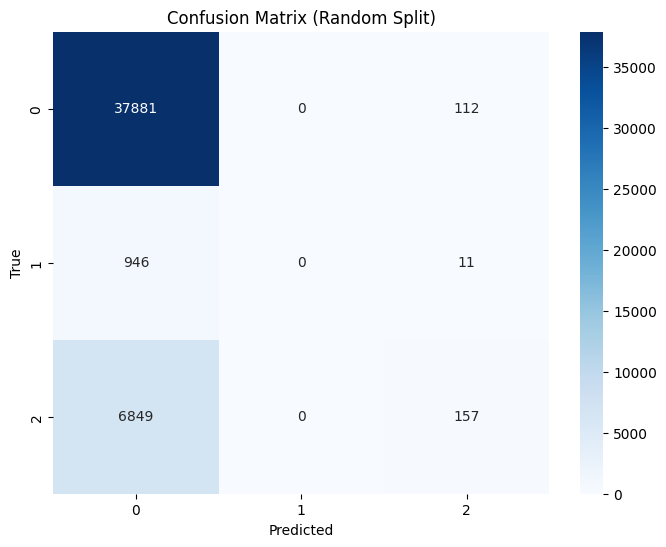

In [11]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_full = cudf.DataFrame.from_pandas(full_dataset)
# Separate features and target variable
X_cudf = cudf_full.drop(columns=['Diabetes_012'])
y_cudf = cudf_full['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns
import matplotlib.pyplot as plt
print("classification report")
print(classification_report(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy()))
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Accuracy (Random Split): 0.5129
Precision: 0.5356
Recall: 0.5129
F1 Score: 0.4426


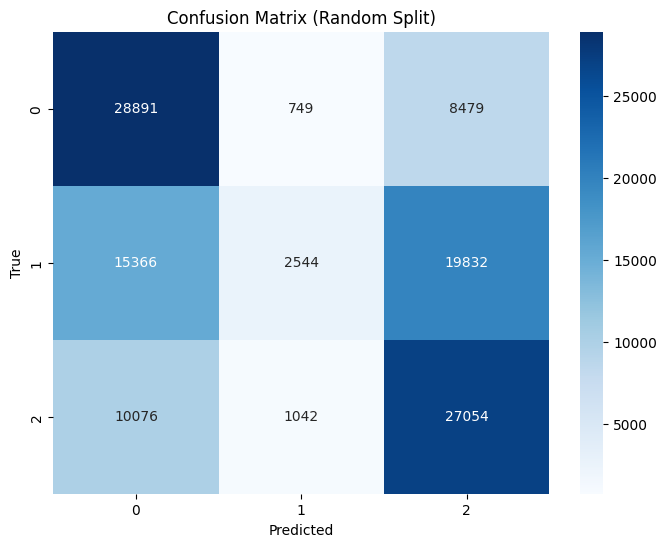

In [10]:
import cudf
import cupy as cp
from cuml.svm import SVC
from cuml.metrics import accuracy_score as cuml_accuracy_score
from cuml.model_selection import train_test_split as cuml_train_test_split
#convert pandas dataframe to cudf dataframe
cudf_smote = cudf.DataFrame.from_pandas(resampled_dataset)
# Separate features and target variable
X_cudf = cudf_smote.drop(columns=['Diabetes_012'])
y_cudf = cudf_smote['Diabetes_012']

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovr')
# Random split of the resampled dataset
X_train_random_cudf, X_test_random_cudf, y_train_random_cudf, y_test_random_cudf = cuml_train_test_split(X_cudf, y_cudf, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf, y_train_random_cudf)
# Make predictions on the test set
y_pred_random_cudf = svm_model.predict(X_test_random_cudf)
# Calculate accuracy
accuracy_random_cudf = cuml_accuracy_score(y_test_random_cudf, y_pred_random_cudf)
print(f"Accuracy (Random Split): {accuracy_random_cudf:.4f}")
#precision
from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision in pandas
precision = precision_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
recall = recall_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
f1 = f1_score(y_test_random_cudf.to_numpy(), y_pred_random_cudf.to_numpy(), average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


Precision: 0.5375
Recall: 0.5383
F1 Score: 0.5348


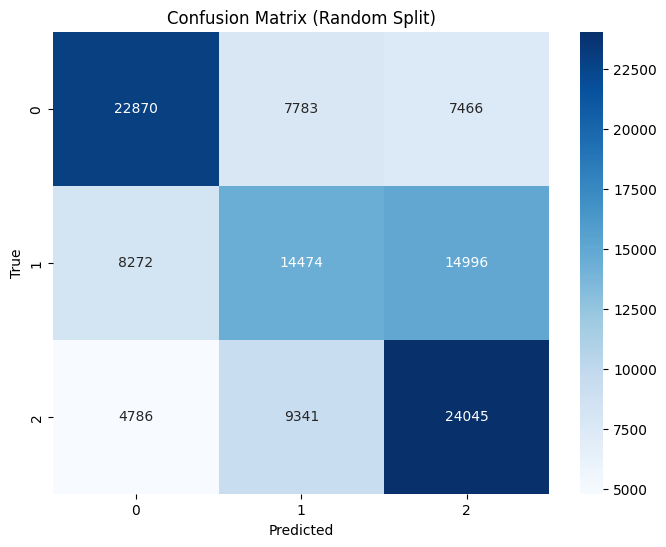

In [9]:
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Convert cudf DataFrame to pandas DataFrame for confusion matrix
y_test_random_cudf = y_test_random_cudf.to_pandas()
y_pred_random_cudf = y_pred_random_cudf.to_pandas()
conf_matrix_random_cudf = confusion_matrix(y_test_random_cudf, y_pred_random_cudf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_random_cudf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Split)')
plt.xlabel('Predicted') 
plt.ylabel('True')
plt.show()


In [15]:
#SVC in rus tomex and near miss

#convert pandas dataframe to cudf dataframe
X_cudf_rus = cudf.DataFrame.from_pandas(X_rus)
y_cudf_rus = cudf.Series(y_rus)

X_cudf_tomek = cudf.DataFrame.from_pandas(X_tomek)
y_cudf_tomek = cudf.Series(y_tomek)

X_cudf_nm = cudf.DataFrame.from_pandas(X_nm)
y_cudf_nm = cudf.Series(y_nm)

#svm model
svm_model = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')
# Random split of the resampled dataset
X_train_random_cudf_rus, X_test_random_cudf_rus, y_train_random_cudf_rus, y_test_random_cudf_rus = cuml_train_test_split(X_cudf_rus, y_cudf_rus, test_size=0.2, random_state=42)
svm_model.fit(X_train_random_cudf_rus, y_train_random_cudf_rus)
y_pred_random_cudf_rus = svm_model.predict(X_test_random_cudf_rus)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))
print("classification report random undersampling")
print(classification_report(y_test_random_cudf_rus.to_numpy(), y_pred_random_cudf_rus.to_numpy()))

X_train_tomek, X_test_tomek, y_train_tomek, y_test_tomek = cuml_train_test_split(X_cudf_tomek, y_cudf_tomek, test_size=0.2, random_state=42)
svm_model.fit(X_train_tomek, y_train_tomek)
y_pred_random_cudf_tomek = svm_model.predict(X_test_tomek)

# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

print("classification report Tomek links")
print(classification_report(y_test_tomek.to_numpy(), y_pred_random_cudf_tomek.to_numpy()))

X_train_nm, X_test_nm, y_train_nm, y_test_nm = cuml_train_test_split(X_cudf_nm, y_cudf_nm, test_size=0.2, random_state=42)
svm_model.fit(X_train_nm, y_train_nm)
y_pred_random_cudf_nm = svm_model.predict(X_test_nm)
# Calculate classification report
print("confusion matrix")
print(confusion_matrix(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))
print("classification report near misss")
print(classification_report(y_test_nm.to_numpy(), y_pred_random_cudf_nm.to_numpy()))

confusion matrix
[[515 247 160]
 [257 290 375]
 [137 269 527]]
classification report random undersampling
              precision    recall  f1-score   support

         0.0       0.57      0.56      0.56       922
         1.0       0.36      0.31      0.34       922
         2.0       0.50      0.56      0.53       933

    accuracy                           0.48      2777
   macro avg       0.47      0.48      0.48      2777
weighted avg       0.47      0.48      0.48      2777

confusion matrix
[[36104     0    70]
 [  925     0     9]
 [ 5295     0   144]]
classification report Tomek links
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92     36174
         1.0       0.00      0.00      0.00       934
         2.0       0.65      0.03      0.05      5439

    accuracy                           0.85     42547
   macro avg       0.50      0.34      0.32     42547
weighted avg       0.81      0.85      0.79     42547



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

confusion matrix
[[695   0 227]
 [113 604 205]
 [338  17 578]]
classification report near misss
              precision    recall  f1-score   support

         0.0       0.61      0.75      0.67       922
         1.0       0.97      0.66      0.78       922
         2.0       0.57      0.62      0.59       933

    accuracy                           0.68      2777
   macro avg       0.72      0.68      0.68      2777
weighted avg       0.72      0.68      0.68      2777



In [17]:
class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size_1,hidden_seize_2, output_size):
        super(neural_net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_seize_2)
        self.fc3 = nn.Linear(hidden_seize_2, output_size)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x
    




In [18]:
model=neural_net(input_size=20, hidden_size_1=64, hidden_seize_2=32, output_size=3).to(device)
print(model)

neural_net(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


In [24]:
from sklearn.model_selection import KFold
import torch

# Prepare data for PyTorch
X = torch.tensor(X_resampled.values, dtype=torch.float32)
y = torch.tensor(y_resampled.values, dtype=torch.int64)

# K-Fold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
num_epochs = 20
input_size = X.shape[1]
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 3
batch_size = 256

fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    fold_accuracies.append(acc)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"Mean cross-validated accuracy over 5 folds: {np.mean(fold_accuracies):.4f}")


  

Fold 1 accuracy: 0.7056
Fold 2 accuracy: 0.7054
Fold 3 accuracy: 0.7177
Fold 4 accuracy: 0.6952
Fold 5 accuracy: 0.7004
Fold 6 accuracy: 0.6948
Fold 7 accuracy: 0.7007
Fold 8 accuracy: 0.7004
Fold 9 accuracy: 0.6886
Fold 10 accuracy: 0.6985
Mean cross-validated accuracy over 5 folds: 0.7007


In [25]:
from sklearn.metrics import classification_report

def run_kfold_nn(X_df, y_series, input_size, hidden_size_1, hidden_size_2, output_size, num_epochs=20, batch_size=256):
    X_tensor = torch.tensor(X_df.values, dtype=torch.float32)
    y_tensor = torch.tensor(y_series.values, dtype=torch.int64)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
        model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        all_preds = []
        all_true = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_true.extend(yb.cpu().numpy())
        acc = np.mean(np.array(all_preds) == np.array(all_true))
        fold_accuracies.append(acc)
        print(f"Fold {fold+1} accuracy: {acc:.4f}")
        print(f"Classification report for fold {fold+1}:\n{classification_report(all_true, all_preds)}")

    print(f"Mean cross-validated accuracy over 10 folds: {np.mean(fold_accuracies):.4f}")
    return fold_accuracies

# Prepare datasets
datasets = [
    ("RandomUnderSampler", X_rus, y_rus),
    ("TomekLinks", X_tomek, y_tomek),
    ("NearMiss", X_nm, y_nm)
]

for name, X_df, y_series in datasets:
    print(f"\n{name} dataset:")
    run_kfold_nn(
        X_df, y_series,
        input_size=X_df.shape[1],
        hidden_size_1=hidden_size_1,
        hidden_size_2=hidden_size_2,
        output_size=output_size,
        num_epochs=num_epochs,
        batch_size=256
    )



RandomUnderSampler dataset:
Fold 1 accuracy: 0.5133
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       464
           1       0.44      0.20      0.28       481
           2       0.47      0.73      0.57       444

    accuracy                           0.51      1389
   macro avg       0.51      0.52      0.49      1389
weighted avg       0.51      0.51      0.49      1389

Fold 2 accuracy: 0.4888
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57       470
           1       0.37      0.28      0.32       452
           2       0.50      0.60      0.55       467

    accuracy                           0.49      1389
   macro avg       0.48      0.49      0.48      1389
weighted avg       0.48      0.49      0.48      1389

Fold 3 accuracy: 0.4917
Classification report for fold 3:
              precision    recall  

/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 2 accuracy: 0.8539
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18165
           1       0.00      0.00      0.00       459
           2       0.00      0.00      0.00      2650

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 3 accuracy: 0.8490
Classification report for fold 3:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18062
           1       0.00      0.00      0.00       506
           2       0.00      0.00      0.00      2706

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.72      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 4 accuracy: 0.8529
Classification report for fold 4:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18144
           1       0.00      0.00      0.00       453
           2       0.00      0.00      0.00      2677

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 5 accuracy: 0.8520
Classification report for fold 5:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18125
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2697

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.78     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 6 accuracy: 0.8535
Classification report for fold 6:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18157
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2659

    accuracy                           0.85     21274
   macro avg       0.28      0.33      0.31     21274
weighted avg       0.73      0.85      0.79     21274



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 7 accuracy: 0.8539
Classification report for fold 7:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18166
           1       0.00      0.00      0.00       458
           2       0.00      0.00      0.00      2649

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.79     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 8 accuracy: 0.8468
Classification report for fold 8:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18013
           1       0.00      0.00      0.00       470
           2       0.00      0.00      0.00      2790

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 9 accuracy: 0.8523
Classification report for fold 9:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18130
           1       0.00      0.00      0.00       480
           2       0.00      0.00      0.00      2663

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.73      0.85      0.78     21273



/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 10 accuracy: 0.8494
Classification report for fold 10:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18069
           1       0.00      0.00      0.00       452
           2       0.00      0.00      0.00      2752

    accuracy                           0.85     21273
   macro avg       0.28      0.33      0.31     21273
weighted avg       0.72      0.85      0.78     21273

Mean cross-validated accuracy over 10 folds: 0.8516

NearMiss dataset:


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Fold 1 accuracy: 0.7019
Classification report for fold 1:
              precision    recall  f1-score   support

           0       0.69      0.66      0.68       464
           1       0.92      0.73      0.81       481
           2       0.56      0.72      0.63       444

    accuracy                           0.70      1389
   macro avg       0.72      0.70      0.71      1389
weighted avg       0.73      0.70      0.71      1389

Fold 2 accuracy: 0.6940
Classification report for fold 2:
              precision    recall  f1-score   support

           0       0.65      0.70      0.68       470
           1       0.96      0.70      0.81       452
           2       0.57      0.68      0.62       467

    accuracy                           0.69      1389
   macro avg       0.73      0.69      0.70      1389
weighted avg       0.73      0.69      0.70      1389

Fold 3 accuracy: 0.6926
Classification report for fold 3:
              precision    recall  f1-score   support

         

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Prepare datasets for grid search
undersampled_datasets = [
    ("RandomUnderSampler", X_rus, y_rus),
    ("TomekLinks", X_tomek, y_tomek),
    ("NearMiss", X_nm, y_nm)
]

# Define parameter grid for MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (128, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [50,100]
}

for name, X_df, y_series in undersampled_datasets:
    print(f"\nGridSearchCV for {name} dataset:")
    mlp = MLPClassifier(random_state=42)
    grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_df, y_series)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validated accuracy: {:.4f}".format(grid_search.best_score_))


GridSearchCV for RandomUnderSampler dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.4987

GridSearchCV for TomekLinks dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (64, 32), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.8588

GridSearchCV for NearMiss dataset:
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
 

Best parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'max_iter': 50, 'solver': 'adam'}
Best cross-validated accuracy: 0.6869


/home/tiago/.pyenv/versions/cuml3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
from imblearn.over_sampling import ADASYN

# Separate features and target variable from the original dataset
X = full_dataset.drop(columns=['Diabetes_012'])
y = full_dataset['Diabetes_012']

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)

# Combine resampled features and target into a new DataFrame
adasyn_dataset = pd.concat([pd.DataFrame(X_adasyn, columns=X.columns), pd.DataFrame(y_adasyn, columns=['Diabetes_012'])], axis=1)

print("Original dataset shape:", y.value_counts())
print("ADASYN resampled dataset shape:", y_adasyn.value_counts())

Original dataset shape: Diabetes_012
0.0    190055
2.0     35097
1.0      4629
Name: count, dtype: int64
ADASYN resampled dataset shape: Diabetes_012
1.0    191592
0.0    190055
2.0    188067
Name: count, dtype: int64


In [28]:
from sklearn.metrics import classification_report

# Prepare ADASYN dataset for PyTorch
X_adasyn_tensor = torch.tensor(X_adasyn.values, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.int64)

# K-Fold Cross Validation on ADASYN dataset
fold_accuracies_adasyn = []
all_preds = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_adasyn_tensor)):
    model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    X_train, X_val = X_adasyn_tensor[train_idx], X_adasyn_tensor[val_idx]
    y_train, y_val = y_adasyn_tensor[train_idx], y_adasyn_tensor[val_idx]

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256)

    for epoch in range(num_epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct = 0
    total = 0
    fold_preds = []
    fold_true = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == yb).sum().item()
            total += yb.size(0)
            fold_preds.extend(predicted.cpu().numpy())
            fold_true.extend(yb.cpu().numpy())
    acc = correct / total
    fold_accuracies_adasyn.append(acc)
    all_preds.extend(fold_preds)
    all_true.extend(fold_true)
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"Mean cross-validated accuracy over 10 folds (ADASYN): {np.mean(fold_accuracies_adasyn):.4f}")
print("Final classification report (ADASYN):")
print(classification_report(all_true, all_preds))

Fold 1 accuracy: 0.6807
Fold 2 accuracy: 0.6967
Fold 3 accuracy: 0.6928
Fold 4 accuracy: 0.7003
Fold 5 accuracy: 0.6970
Fold 6 accuracy: 0.6893
Fold 7 accuracy: 0.6908
Fold 8 accuracy: 0.7043
Fold 9 accuracy: 0.7086
Fold 10 accuracy: 0.7032
Mean cross-validated accuracy over 10 folds (ADASYN): 0.6964
Final classification report (ADASYN):
              precision    recall  f1-score   support

           0       0.76      0.85      0.80    190055
           1       0.69      0.71      0.70    191592
           2       0.62      0.53      0.57    188067

    accuracy                           0.70    569714
   macro avg       0.69      0.70      0.69    569714
weighted avg       0.69      0.70      0.69    569714



In [ ]:
import itertools

# Define parameter grid
param_grid = {
    'hidden_size_1': [64, 128],
    'hidden_size_2': [32, 64],
    'lr': [0.001, 0.0005],
    'num_epochs': [10, 20]
}

# Prepare data
X = torch.tensor(X_adasyn.values, dtype=torch.float32)
y = torch.tensor(y_adasyn.values, dtype=torch.int64)

best_acc = 0
best_params = None

for params in itertools.product(*param_grid.values()):
    hidden_size_1, hidden_size_2, lr, num_epochs = params
    fold_accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        model = neural_net(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=256)

        for epoch in range(num_epochs):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                outputs = model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        fold_accuracies.append(acc)
    mean_acc = np.mean(fold_accuracies)
    print(f"Params: {params}, Mean CV Accuracy: {mean_acc:.4f}")
    if mean_acc > best_acc:
        best_acc = mean_acc
        best_params = params

print(f"Best params: {best_params}, Best mean CV accuracy: {best_acc:.4f}")

Params: (64, 32, 0.001, 10), Mean CV Accuracy: 0.6273
Params: (64, 32, 0.001, 20), Mean CV Accuracy: 0.6607
Params: (64, 32, 0.0005, 10), Mean CV Accuracy: 0.5950
Params: (64, 32, 0.0005, 20), Mean CV Accuracy: 0.6321
Params: (64, 64, 0.001, 10), Mean CV Accuracy: 0.6350
Params: (64, 64, 0.001, 20), Mean CV Accuracy: 0.6661
Params: (64, 64, 0.0005, 10), Mean CV Accuracy: 0.6058
Params: (64, 64, 0.0005, 20), Mean CV Accuracy: 0.6435
Params: (128, 32, 0.001, 10), Mean CV Accuracy: 0.6519
